# Preparação do Ambiente

In [66]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import ale_py
from IPython.display import HTML, display
from matplotlib import animation

gym.register_envs(ale_py)

In [67]:
torch.manual_seed(42)
np.random.seed(42)

In [68]:
def moving_average(rewards, window_size=10):
    n = len(rewards)
    grouped_means = [np.mean(rewards[i:i+window_size]) for i in range(0, n, window_size)]
    grouped_indices = [i for i in range(0, n, window_size)]
    return grouped_indices, grouped_means

In [69]:
def plot_rewards(train_rewards, test_rewards=None, title=None, max_reward=None, window_size=10):
    if test_rewards is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        axes = [axes]

    # TRAINING
    axes[0].plot(train_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
    train_x, train_avg = moving_average(train_rewards, window_size)
    axes[0].plot(train_x, train_avg, label=f'Média a cada {window_size}', color='orange')
    axes[0].set_title("Training")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward")

    if max_reward is not None:
        axes[0].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

    axes[0].legend()

    # TESTING
    if test_rewards is not None:
        axes[1].plot(test_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
        test_x, test_avg = moving_average(test_rewards, window_size)
        axes[1].plot(test_x, test_avg, label=f'Média a cada {window_size}', color='orange')
        axes[1].set_title("Testing")
        axes[1].set_xlabel("Episodes")
        axes[1].set_ylabel("Reward")

        if max_reward is not None:
            axes[1].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

        axes[1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

# Prioritized Experience Replay (PER)

In [70]:
class SumTree:
   def __init__(self, capacity: int):
      self.capacity = capacity
      # A árvore tem (2 * capacity - 1) nós no total.
      self.tree = np.zeros(2 * capacity - 1)
      self.data_pointer = 0

   def add(self, priority: float, data_index: int):
      """ Adiciona uma nova prioridade na árvore. """
      tree_index = self.data_pointer + self.capacity - 1

      self.update(tree_index, priority)

      self.data_pointer = (self.data_pointer + 1) % self.capacity

   def update(self, tree_index: int, priority: float):
      """ Atualiza a prioridade de um nó e propaga a mudança para cima. """
      change = priority - self.tree[tree_index]
      self.tree[tree_index] = priority

      # Propaga a mudança para a raiz
      while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

   def get_leaf(self, value: float) -> (int, float, int):
      """ Encontra a amostra (índice da árvore, prioridade, índice do dado) para um dado valor. """
      parent_index = 0
      while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # Chegou em uma folha
            if left_child_index >= len(self.tree):
               leaf_index = parent_index
               break
            else:
               if value <= self.tree[left_child_index]:
                  parent_index = left_child_index
               else:
                  value -= self.tree[left_child_index]
                  parent_index = right_child_index

      data_index = leaf_index - self.capacity + 1
      return leaf_index, self.tree[leaf_index], data_index

   @property
   def total_priority(self) -> float:
      """ Retorna a prioridade total (valor na raiz). """
      return self.tree[0]

In [71]:
class PrioritizedReplayBuffer:
   def __init__(self, capacity: int, alpha: float = 0.6):
      self._alpha = alpha
      self._capacity = capacity
      self._size = 0
      self._index = 0

      # Estruturas de dados
      self._memory = np.empty(capacity, dtype=object)
      self._tree = SumTree(capacity)

      # Constantes
      self.PER_e = 1e-6
      self.max_priority = 1.0

   def __len__(self):
      return self._size

   def store(self, state, action, reward, next_state, done):
      """ Armazena uma nova transição e dá a ela a prioridade máxima. """
      experience = (state, action, reward, next_state, done)
      self._memory[self._index] = experience

      # Adiciona a prioridade na SumTree
      self._tree.add(self.max_priority, self._index)

      # Atualiza os ponteiros
      self._index = (self._index + 1) % self._capacity
      self._size = min(self._size + 1, self._capacity)

   def sample(self, batch_size: int, beta: float = 0.4):
      """ Amostra um batch de transições usando a SumTree. """
      assert self._size >= batch_size, "Buffer tem menos amostras que o batch_size"

      batch_indices = np.empty(batch_size, dtype=np.int32)
      tree_indices = np.empty(batch_size, dtype=np.int32)
      priorities = np.empty(batch_size, dtype=np.float32)

      segment = self._tree.total_priority / batch_size

      for i in range(batch_size):
         a = segment * i
         b = segment * (i + 1)
         value = np.random.uniform(a, b)
         tree_idx, priority, data_idx = self._tree.get_leaf(value)

         priorities[i] = priority
         batch_indices[i] = data_idx
         tree_indices[i] = tree_idx

      # Calcula os pesos de Importance Sampling (IS)
      sampling_probabilities = priorities / self._tree.total_priority
      weights = np.power(self._size * sampling_probabilities, -beta)
      weights /= weights.max() # Normaliza para estabilidade

      # Extrai os dados das transições
      states, actions, rewards, next_states, dones = zip(*self._memory[batch_indices])

      return (
         np.array(states, dtype=np.float32) / 255,
         np.array(actions),
         np.array(rewards, dtype=np.float32),
         np.array(next_states, dtype=np.float32) / 255,
         np.array(dones, dtype=np.int32),
         weights.astype(np.float32),
         tree_indices
      )

   def update_priorities(self, tree_indices: np.ndarray, errors: np.ndarray):
      """ Atualiza as prioridades na SumTree após um passo de aprendizado. """
      priorities = (np.abs(errors) + self.PER_e) ** self._alpha

      for ti, p in zip(tree_indices, priorities):
         self._tree.update(ti, p)

      self.max_priority = max(self.max_priority, np.max(priorities))

# Definição da Rede

In [72]:
class AtariDQN(nn.Module):
  def __init__(self, action_shape):
    super(AtariDQN, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(4, 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU(),
    )
    self.fc = nn.Sequential(
        nn.Linear(64 * 7 * 7, 512),
        nn.ReLU(),
        nn.Linear(512, action_shape)
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)    
    x = self.fc(x)
    return x

# Definição do Agente

In [73]:
class PrioritizedAtariDQNAgent():
   def __init__(self, env,
                target_update=20,
                epsilon=1,
                alpha=1e-3,
                gamma=0.999,
                epsilon_decay=0.998,
                epsilon_min=0.01,
                batch_size=64,
                replay_buffer_size=100000,
                beta=0.4,
                beta_decay=1e-5):
      self.epsilon = epsilon
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon_decay = epsilon_decay
      self.epsilon_min = epsilon_min
      self.batch_size = batch_size
      self.beta = beta
      self.beta_decay = beta_decay
      self.target_update = target_update

      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.env = env

      self.dqn = AtariDQN(env.action_space.n).to(self.device)
      self.dqn_target = AtariDQN(env.action_space.n).to(self.device)

      self.dqn_target.load_state_dict(self.dqn.state_dict())
      self.dqn_target.eval()

      self.replay = PrioritizedReplayBuffer(replay_buffer_size)

      self.optimizer = optim.Adam(self.dqn.parameters(), lr=alpha)
      self.loss = nn.SmoothL1Loss(reduction='none')

   def _update_dqn_target(self):
      self.dqn_target.load_state_dict(self.dqn.state_dict())

   def act(self, state):
      self.dqn.eval()

      if np.random.rand() < self.epsilon:
         return self.env.action_space.sample()

      with torch.no_grad():
         state = torch.tensor(state, dtype=torch.float32).to(self.device)
         if state.ndim == 3:
            state = state.unsqueeze(0)
         action = self.dqn(state).argmax(dim=-1).item()

      return action

   def update(self):
      self.dqn.train()

      states, actions, rewards, next_states, dones, weights, indices = self.replay.sample(self.batch_size, self.beta)

      states = torch.as_tensor(states, dtype=torch.float32, device=self.device)
      actions = torch.as_tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(-1)
      rewards = torch.as_tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(-1)
      next_states = torch.as_tensor(next_states, dtype=torch.float32, device=self.device)
      dones = torch.as_tensor(dones, dtype=torch.float32, device=self.device).unsqueeze(-1)
      weights = torch.as_tensor(weights, dtype=torch.float32, device=self.device).unsqueeze(-1)

      q_eval = self.dqn(states).gather(-1, actions.long())

      with torch.no_grad():
         next_actions = self.dqn(next_states).argmax(dim=1, keepdim=True)
         q_next = self.dqn_target(next_states).gather(1, next_actions)
         q_target = rewards + self.gamma * q_next * (1 - dones)

      losses = self.loss(q_eval, q_target)
      loss = torch.mean(losses * weights)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      td_errors = (q_target - q_eval).detach().cpu().numpy().reshape(-1)
      self.replay.update_priorities(indices, td_errors)

      self.beta = min(1, self.beta + self.beta_decay)

   def train(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Training", disable=not verbose)
      rewards = []
      count_update = 0

      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False

         while not done:
            action = self.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.replay.store(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(self.replay) > self.batch_size:
               self.update()
               count_update += 1

               if count_update % self.target_update == 0:
                  self._update_dqn_target()

         self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward, "Epsilon": self.epsilon })

      return rewards

   def evaluate(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Evaluating", disable=not verbose)
      rewards = []

      epsilon_real = self.epsilon
      self.epsilon = 0

      self.dqn.eval()

      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False

         while not done:
            action = self.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            state = next_state
            episode_reward += reward

         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward })

      self.epsilon = epsilon_real

      return rewards

   def save(self, path):
      torch.save(self.dqn.state_dict(), path)

   def load(self, path):
      self.dqn.load_state_dict(torch.load(path))
      

   def render(self, env, max_steps: int = 500, interval: int = 30, figsize: tuple = (6, 6)):
      """
      Executa o agente no ambiente por até max_steps, captura frames e exibe
      uma animação inline no notebook.
      """
      frames = []
      state, _ = env.reset()
      done = False

      for _ in range(max_steps):
         # captura frame como array RGB
         frame = env.render()
         frames.append(frame)

         # ação greedy (sem exploração)
         action = self.act(state)
         state, reward, terminated, truncated, _ = env.step(action)
         done = terminated or truncated
         if done:
               break

      # fecha o ambiente
      env.close()

      # monta figure/axis
      fig = plt.figure(figsize=figsize)
      plt.axis("off")
      im = plt.imshow(frames[0])

      # função de atualização para cada frame
      def animate(i):
         im.set_array(frames[i])
         return [im]

      # cria a animação
      anim = animation.FuncAnimation(
         fig, animate, frames=len(frames), interval=interval
      )
      display(HTML(anim.to_jshtml()))

# Ambientes

In [74]:
envs = [
    ("ALE/Pong-v5",           "Pong",           "pong_ataridper.pt"         ),
    ("ALE/Breakout-v5",       "Breakout",       "breakout_ataridper.pt"     ),
    ("ALE/SpaceInvaders-v5",  "SpaceInvaders",  "spaceinvaders_ataridper.pt"),
    ("ALE/Qbert-v5",          "Q*Bert",         "qbert_ataridper.pt"        ),
]

Training Pong...


Evaluating: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it, Reward=-21]


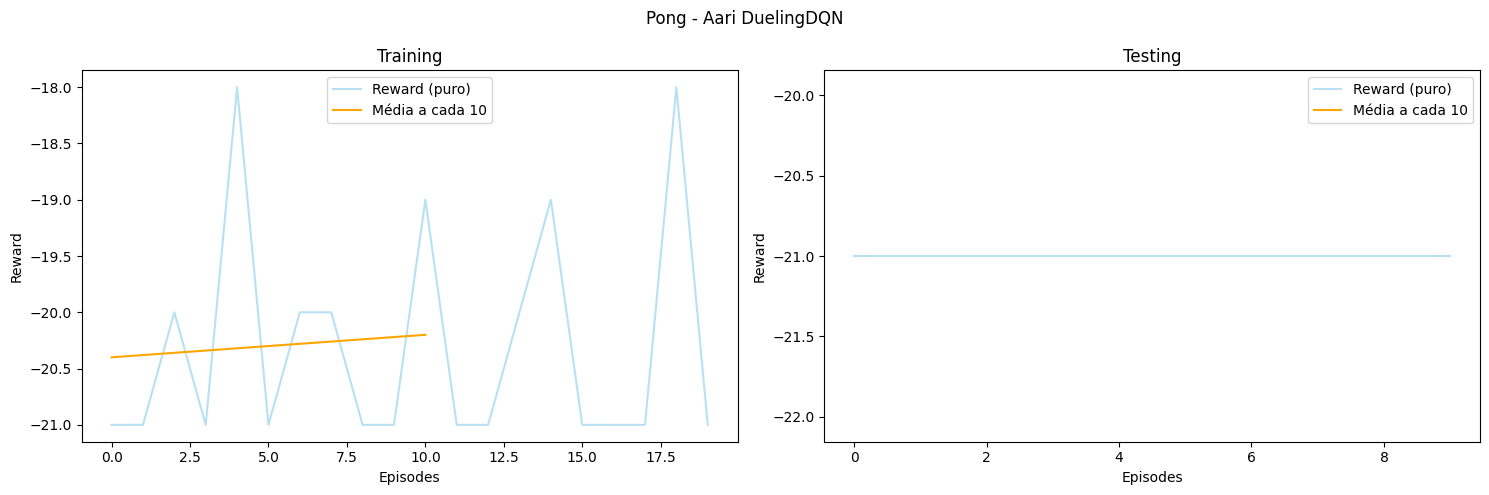

RuntimeError: Given groups=1, weight of size [32, 4, 8, 8], expected input[1, 210, 160, 3] to have 4 channels, but got 210 channels instead

In [ ]:

for env_name, env_title, path in envs:
   print(f"Training {env_title}...")

   env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
   env = AtariPreprocessing(env, frame_skip=4, screen_size=84, grayscale_obs=True)
   env = FrameStackObservation(env, 4)

   agent = PrioritizedAtariDQNAgent(env, beta_decay=(1 - 0.4) / 20, epsilon_decay=0.9)

   train_rewards = agent.train(20, verbose=True)
   test_rewards = agent.evaluate(10, verbose=True)

   agent.save(f'checkpoint/{path}')

   plot_rewards(train_rewards, test_rewards, f"{env_title} - Aari DuelingDQN")
   
   agent.render(env, max_steps=500, interval=30, figsize=(6, 6))

   print("Done!\n")